In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [16]:
!cp -r '/content/gdrive/My Drive/MURA-v1.1.zip' MURA-v1.1.zip
!unzip MURA-v1.1.zip

Output hidden; open in https://colab.research.google.com to view.

In [0]:

import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
import pdb
import random
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
from PIL import Image
import torchvision.models as models
%matplotlib inline
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
class MuraDataset(torch.utils.data.Dataset):
    
    def __init__(self,text_file,root_dir, transform ):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        #File with the Path
        self.name_frame = pd.read_csv(text_file,sep=",",usecols=[0],dtype = 'str')
        #File with labels
        self.label_frame = pd.read_csv(text_file,sep=",")
        self.root_dir = root_dir
        self.transform = transform
                                       
    def __len__(self):
        return len(self.name_frame)

    def __getitem__(self, idx):
        #Pull image
        img_name = os.path.join(self.root_dir, self.name_frame.iloc[idx, 0])
        img_path = self.name_frame.iloc[idx, 0]
        
        #Apply adapative threshold to highlight key features in the image   
        if not os.path.exists(img_name):
          print(img_name)
        else:
          image = cv2.imread(img_name,0)
          image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)  
          image = Image.fromarray(image)
          image = image.convert('L')

          #Apply tensor transformations to images
          image = self.transform(image) 
          
          #Abnormal Class
          abnormal = self.label_frame.iloc[idx,1]
          
          # I included labels in the train_image_path file in excel using a find("positive")
          labels = self.label_frame.iloc[idx,10]
          labels = np.array(labels)

          #Formatting for labels
          labels = np.array(labels)
          labels= torch.from_numpy(labels.astype('int64'))

        sample = {'image': image, 'labels': labels, 'paths': img_path, 'abnormal': abnormal}
        
        return sample

In [0]:
MuraTrainSet = MuraDataset(text_file ='/content/MURA-v1.1/train_image_paths.csv',
                           root_dir = '/content',
                          transform = transforms.Compose([transforms.Resize((227,227)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(
                                                              mean=[0.456],
                                                              std= [0.225])]))

MuraTrainLoader = torch.utils.data.DataLoader(MuraTrainSet,batch_size=1024,shuffle=True, num_workers=0)

MuraTestSet = MuraDataset(text_file ='/content/MURA-v1.1/valid_image_paths.csv',
                           root_dir = '/content',
                          transform = transforms.Compose([transforms.Resize((227,227)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(
                                                              mean=[0.456],
                                                              std= [0.225])]))

MuraTestLoader = torch.utils.data.DataLoader(MuraTestSet,batch_size=1024,shuffle=True, num_workers=0)



In [13]:
alex_net = models.alexnet(pretrained=True)
for param in alex_net.parameters():
    param.requires_grad = False
#Adjust Model can read gray scale images
alex_net.features._modules['0'] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#Adjust Output
alex_net.classifier._modules['6'] = nn.Linear(4096, 7)
alex_net.to(device)



AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [0]:
import torch.optim as optim
#************************************#

# 4.2 Train the model
# 4.3 Please store and print training and validation loss&accuracy after each epoch
#********************************************#

def alex_train(epoch, max_batch, lr, w, optimize, train_losses, acc_data_train):
    alex_net.train()
    train_loss = 0
    correct = 0
    for i, sample_batched in enumerate(MuraTrainLoader,1):
        if i <max_batch:
            inputs = sample_batched['image'].to(device)
            labels = sample_batched['labels'].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = alex_net(inputs)
            loss = criterion(F.log_softmax(outputs, dim=1), labels)
            loss.backward()
            optimizer.step()

            train_loss+= loss.item()
            pred = outputs.data.max(1, keepdim=True)[1].int()
            #print(pred)
            labels = labels.int()
            #print(labels)

            correct += pred.eq(labels.data.view_as(pred)).sum()
             
        else:
            #print("Batches Complete: ", max_batch)
            break

    
    accuracy = float(100*float(correct)/36808)

    acc_data_train.append([accuracy])
    train_loss=float(train_loss)/float(i)
    train_losses.append([optimize, lr,w,train_loss])
    # print statistics        
    print('Train Epoch:{}  Accuracy: ({}/{}) {:.2f}%   Average Loss: {:.2f} \n'.
          format(epoch, correct,36808, accuracy, train_loss))

In [0]:
#Adam Random Search : Winner: Optimizer: Adam	Learning Rate: 0.0013	 Weight_Decay: 1.0201e-06
import random
train_losses_hyp = []
acc_data_hyp = []
optimize = 'Adam'

for i in range(64): #Test different optimizer
    lr= round(np.exp(random.uniform(np.log(.0001), np.log(.01))),4) #pull geometrically
    w = round(np.exp(random.uniform(np.log(3.1e-7), np.log(3.1e-5))),10) #pull geometrically

    #Reset Model per test
    alex_net = models.alexnet(pretrained=True)
    for param in alex_net.parameters():
        param.requires_grad = False
    alex_net.features._modules['0'] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    #Adjust Output
    alex_net.classifier._modules['6'] = nn.Linear(4096, 7)
    alex_net.to(device)
    optimizer = optim.Adam(alex_net.parameters(), lr=lr, weight_decay=w, amsgrad=True)
    criterion = nn.CrossEntropyLoss()
    print('Optimizer: Adam\tLearning Rate: {}\t Weight_Decay: {}'.
          format (lr, w))
    alex_train(i,10000,lr,w,optimize,train_losses_hyp, acc_data_hyp)

Optimizer: Adam	Learning Rate: 0.0036	 Weight_Decay: 4.836e-07
Train Epoch:0  Accuracy: (16571/9680000) 47.55%   Average Loss: 1.52 

Optimizer: Adam	Learning Rate: 0.0005	 Weight_Decay: 1.0766e-05
Train Epoch:1  Accuracy: (17417/9680000) 49.98%   Average Loss: 1.46 

Optimizer: Adam	Learning Rate: 0.0009	 Weight_Decay: 6.035e-07
Train Epoch:2  Accuracy: (18171/9680000) 52.14%   Average Loss: 1.41 

Optimizer: Adam	Learning Rate: 0.0013	 Weight_Decay: 1.0201e-06
Train Epoch:3  Accuracy: (23338/9680000) 66.97%   Average Loss: 1.06 

Optimizer: Adam	Learning Rate: 0.0001	 Weight_Decay: 1.1309e-06
Train Epoch:4  Accuracy: (14222/9680000) 40.81%   Average Loss: 1.69 

Optimizer: Adam	Learning Rate: 0.0045	 Weight_Decay: 1.022e-06
Train Epoch:5  Accuracy: (17917/9680000) 51.41%   Average Loss: 1.44 

Optimizer: Adam	Learning Rate: 0.0005	 Weight_Decay: 1.8121e-06
Train Epoch:6  Accuracy: (20501/9680000) 58.83%   Average Loss: 1.26 

Optimizer: Adam	Learning Rate: 0.0073	 Weight_Decay: 6.034

In [0]:
#SGD Random Search
import random
train_losses_hyp = []
acc_data_hyp = []
optimize = 'SGD'

for i in range(64): #Test different optimizer
    lr= round(np.exp(random.uniform(np.log(.001), np.log(.1))),4) #pull geometrically
    w = round(np.exp(random.uniform(np.log(.09), np.log(.99))),3) #pull geometrically
    nest= bool(random.getrandbits(1))

    #Reset Model per test
    alex_net = models.alexnet(pretrained=True)
    for param in alex_net.parameters():
        param.requires_grad = False
    alex_net.features._modules['0'] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    #Adjust Output
    alex_net.classifier._modules['6'] = nn.Linear(4096, 7)
    alex_net.to(device)
    optimizer = optim.SGD(alex_net.parameters(), lr=lr, momentum=w, nesterov=nest)
    criterion = nn.CrossEntropyLoss()
    print('Optimizer: SGD\tLearning Rate: {}\t Momentum: {}\t Nestrov: {}'.
          format (lr, w, nest))
    
    alex_train(i,10000,lr,w,optimize,train_losses_hyp, acc_data_hyp)
    

Optimizer: SGD	Learning Rate: 0.0087	 Momentum: 0.104	 Nestrov: False
Train Epoch:0  Accuracy: (15631/34848) 44.85%   Average Loss: 1.54 

Optimizer: SGD	Learning Rate: 0.0012	 Momentum: 0.17	 Nestrov: True
Train Epoch:1  Accuracy: (14652/34848) 42.05%   Average Loss: 1.68 

Optimizer: SGD	Learning Rate: 0.0038	 Momentum: 0.874	 Nestrov: True
Train Epoch:2  Accuracy: (17700/34848) 50.79%   Average Loss: 1.47 

Optimizer: SGD	Learning Rate: 0.0222	 Momentum: 0.413	 Nestrov: False
Train Epoch:3  Accuracy: (14239/34848) 40.86%   Average Loss: 1.66 

Optimizer: SGD	Learning Rate: 0.0258	 Momentum: 0.214	 Nestrov: True
Train Epoch:4  Accuracy: (11864/34848) 34.04%   Average Loss: 1.78 

Optimizer: SGD	Learning Rate: 0.0629	 Momentum: 0.831	 Nestrov: True
Train Epoch:5  Accuracy: (7415/34848) 21.28%   Average Loss: 11459023.28 

Optimizer: SGD	Learning Rate: 0.0442	 Momentum: 0.918	 Nestrov: True
Train Epoch:6  Accuracy: (7022/34848) 20.15%   Average Loss: 34.50 

Optimizer: SGD	Learning Rat

KeyboardInterrupt: ignored

In [0]:
import torch
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys
import numpy as np
import argparse

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            #print(x)
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
                
        return outputs, x

class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """
    def __init__(self, model, target_layers):
        self.model = model
        self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations, output  = self.feature_extractor(x)
        output = output.view(output.size(0), -1)
        output = self.model.classifier(output)
        return target_activations, output

def preprocess_image(img):
    means=[0.456]
    stds=[0.225]
    preprocessed_img = img.copy()[: , :, ::-1]
    for i in range(1):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img.copy())
    preprocessed_img.unsqueeze_(0)
    input = Variable(preprocessed_img, requires_grad = True)
    return input

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask),  cv2.COLORMAP_WINTER)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam.jpg", np.uint8(255 * cam))

class GradCam:
    def __init__(self, model, target_layer_names, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, target_layer_names)


    def forward(self, input):
        return self.model(input) 


    def __call__(self, input, index = None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)


        if index == None:
            index = np.argmax(output.cpu().data.numpy())


        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1

        one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)

        else:
            one_hot = torch.sum(one_hot * output)

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)
        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
        
        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis = (2, 3))[0, :]
        cam = np.zeros(target.shape[1 : ], dtype = np.float32)


        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (227, 227))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam



In [0]:
#Adam Random Search : Winner: Optimizer: Adam	Learning Rate: 0.0013	 Weight_Decay: 1.0201e-06
import random
train_losses_hyp = []
acc_data_hyp = []
optimize = 'Adam'

body_parts = ['Forearm','Humerus','Elbow','Shoulder','Hand','Wrist','Finger']
IMG_URL = [['/content/MURA-v1.1/train/XR_FOREARM/patient09089/study2_negative/image1.png',
         '/content/MURA-v1.1/train/XR_FOREARM/patient09270/study2_negative/image2.png',
         '/content/MURA-v1.1/train/XR_FOREARM/patient09083/study1_positive/image1.png',
         '/content/MURA-v1.1/train/XR_FOREARM/patient09083/study1_positive/image2.png',
         '/content/MURA-v1.1/train/XR_FOREARM/patient05601/study1_positive/image1.png'],
        ['/content/MURA-v1.1/train/XR_HUMERUS/patient02938/study1_positive/image2.png',
         '/content/MURA-v1.1/train/XR_HUMERUS/patient02939/study1_positive/image1.png',
         '/content/MURA-v1.1/train/XR_HUMERUS/patient02939/study1_positive/image2.png',
         '/content/MURA-v1.1/train/XR_HUMERUS/patient02940/study1_negative/image1.png',
         '/content/MURA-v1.1/train/XR_HUMERUS/patient02940/study1_negative/image2.png',
         '/content/MURA-v1.1/train/XR_HUMERUS/patient02941/study1_negative/image1.png'],
        ['/content/MURA-v1.1/train/XR_ELBOW/patient04903/study1_positive/image1.png',
         '/content/MURA-v1.1/train/XR_ELBOW/patient04904/study1_positive/image1.png',
         '/content/MURA-v1.1/train/XR_ELBOW/patient04913/study1_positive/image1.png',
         '/content/MURA-v1.1/train/XR_ELBOW/patient00894/study2_negative/image1.png',
         '/content/MURA-v1.1/train/XR_ELBOW/patient04991/study2_negative/image2.png',
         '/content/MURA-v1.1/train/XR_ELBOW/patient05023/study2_negative/image1.png'],
        ['/content/MURA-v1.1/train/XR_SHOULDER/patient01277/study1_positive/image4.png',
         '/content/MURA-v1.1/train/XR_SHOULDER/patient01278/study1_positive/image1.png',
         '/content/MURA-v1.1/train/XR_SHOULDER/patient01363/study1_positive/image3.png',
         '/content/MURA-v1.1/train/XR_SHOULDER/patient01405/study2_negative/image4.png',
         '/content/MURA-v1.1/train/XR_SHOULDER/patient01412/study2_negative/image1.png',
         '/content/MURA-v1.1/train/XR_SHOULDER/patient01454/study1_negative/image4.png'],
         ['/content/MURA-v1.1/train/XR_HAND/patient09740/study1_positive/image3.png',
          '/content/MURA-v1.1/train/XR_HAND/patient03009/study1_positive/image1.png',
          '/content/MURA-v1.1/train/XR_HAND/patient03959/study1_positive/image1.png',
          '/content/MURA-v1.1/train/XR_HAND/patient09740/study2_negative/image1.png',
          '/content/MURA-v1.1/train/XR_HAND/patient00218/study2_negative/image2.png',
          '/content/MURA-v1.1/train/XR_HAND/patient09944/study2_negative/image1.png'],
        ['/content/MURA-v1.1/train/XR_WRIST/patient06361/study1_positive/image3.png',
         '/content/MURA-v1.1/train/XR_WRIST/patient06362/study1_positive/image1.png',
         '/content/MURA-v1.1/train/XR_WRIST/patient06386/study2_negative/image2.png',
         '/content/MURA-v1.1/train/XR_WRIST/patient06396/study3_negative/image3.png',
         '/content/MURA-v1.1/train/XR_WRIST/patient06398/study1_positive/image3.png',
         '/content/MURA-v1.1/train/XR_WRIST/patient06402/study2_negative/image4.png'],
        ['/content/MURA-v1.1/train/XR_FINGER/patient03230/study1_positive/image5.png',
         '/content/MURA-v1.1/train/XR_FINGER/patient03230/study2_negative/image1.png',
         '/content/MURA-v1.1/train/XR_FINGER/patient03237/study1_positive/image1.png',
         '/content/MURA-v1.1/train/XR_FINGER/patient03258/study2_negative/image1.png',
         '/content/MURA-v1.1/train/XR_FINGER/patient03261/study1_positive/image3.png',
         '/content/MURA-v1.1/train/XR_FINGER/patient03269/study2_negative/image3.png']]

for i in range(1): #Test different optimizer
    lr= 0.0013	
    w = 1.0201e-06

    #Reset Model per test
    alex_net = models.alexnet(pretrained=True)
    for param in alex_net.parameters():
        param.requires_grad = False
    alex_net.features._modules['0'] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    #Adjust Output
    alex_net.classifier._modules['6'] = nn.Linear(4096, 7)
    alex_net.to(device)
    optimizer = optim.Adam(alex_net.parameters(), lr=lr, weight_decay=w, amsgrad=True)
    criterion = nn.CrossEntropyLoss()

    for j in range(1,31):
      alex_train(j,10000,lr,w,optimize,train_losses_hyp, acc_data_hyp)
      if j%5==0:
        import copy
        alex_net_grad = copy.deepcopy(alex_net)
        grad_cam = GradCam(model = alex_net_grad,target_layer_names = ["11"], use_cuda=True)

        for k in range(len(IMG_URL)):
          body = body_parts[k]
          path_dest = '/content/gdrive/My Drive/MURA-v1.1/'+ body +'/Alexnet_Images/'
            
          for l in range(len(IMG_URL[k])):
              current_img = IMG_URL[k][l]
              img = cv2.imread(current_img , 0)
              img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2) 
              img = np.float32(cv2.resize(img, (227, 227))) / 255
              img = np.reshape(img,(227,227,1))
              input = preprocess_image(img)

              # If None, returns the map for the highest scoring category.

              # Otherwise, targets the requested index.
              target_index = None
              mask = grad_cam(input, target_index)
              show_cam_on_image(img, mask)
              result = cv2.imread('/content/cam.jpg',1)
              photo_name = 'CAM'+str(l)+'_'+str(j)+'.jpg'
              photo_dest = path_dest+photo_name
              cv2.imwrite(photo_dest, result)

Train Epoch:1  Accuracy: (22131/36808) 60.13%   Average Loss: 1.14 

Train Epoch:2  Accuracy: (29222/36808) 79.39%   Average Loss: 0.62 

Train Epoch:3  Accuracy: (30903/36808) 83.96%   Average Loss: 0.49 

Train Epoch:4  Accuracy: (31961/36808) 86.83%   Average Loss: 0.41 

Train Epoch:5  Accuracy: (32663/36808) 88.74%   Average Loss: 0.35 

Train Epoch:6  Accuracy: (33169/36808) 90.11%   Average Loss: 0.31 

Train Epoch:7  Accuracy: (33513/36808) 91.05%   Average Loss: 0.28 

Train Epoch:8  Accuracy: (33752/36808) 91.70%   Average Loss: 0.26 

Train Epoch:9  Accuracy: (33949/36808) 92.23%   Average Loss: 0.24 

Train Epoch:10  Accuracy: (34130/36808) 92.72%   Average Loss: 0.23 

Train Epoch:11  Accuracy: (34379/36808) 93.40%   Average Loss: 0.21 

Train Epoch:12  Accuracy: (34440/36808) 93.57%   Average Loss: 0.20 

Train Epoch:13  Accuracy: (34468/36808) 93.64%   Average Loss: 0.20 

Train Epoch:14  Accuracy: (34610/36808) 94.03%   Average Loss: 0.19 

Train Epoch:15  Accuracy: (34

In [0]:
PATH = '/content/gdrive/My Drive/MURA-v1.1/Body_Class.pth'
torch.save(alex_net.state_dict(), PATH)

In [0]:
PATH = '/content/gdrive/My Drive/MURA-v1.1/Body_Class.pth'
alex_net.load_state_dict(torch.load(PATH))

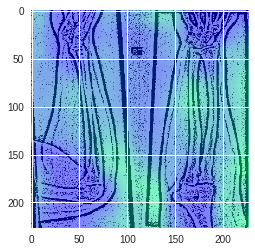

In [0]:
import copy
alex_net_grad = copy.deepcopy(alex_net)
grad_cam = GradCam(model = alex_net_grad,target_layer_names = ["11"], use_cuda=True)

path = ['/content/gdrive/My Drive/MURA-v1.1/train/XR_FOREARM/patient09089/study2_negative/image1.png']

for i in path:
    img = cv2.imread(i, 0)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2) 
    img = np.float32(cv2.resize(img, (227, 227))) / 255
    img = np.reshape(img,(227,227,1))
    input = preprocess_image(img)

    # If None, returns the map for the highest scoring category.

    # Otherwise, targets the requested index.
    target_index = None
    mask = grad_cam(input, target_index)
    show_cam_on_image(img, mask)
    result = cv2.imread('/content/cam.jpg',1)
    cv2.imwrite("/content/gdrive/My Drive/cam.jpg", result)
    

In [0]:
print(img)

None


In [0]:
def alex_test(epoch, pred_array):
    #Have our model in evaluation mode
    alex_net.eval()
    #Set losses and Correct labels to zero
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, sample_batched in enumerate(MuraTestLoader,1):

            inputs = sample_batched['image'].to(device)
            labels = sample_batched['labels'].to(device)
            paths = sample_batched['paths']
            abnormal = sample_batched['abnormal']

            # zero the parameter gradients
            #optimizer.zero_grad()

            # forward + backward + optimize
            outputs = alex_net(inputs)
            loss = criterion(F.log_softmax(outputs, dim=1), labels)
            test_loss+= loss.item()
            pred = outputs.data.max(1, keepdim=True)[1].int()
            #print(pred)
            labels = labels.int()
            pred_array.append([paths, abnormal, pred, labels])
            #print(labels)

            correct += pred.eq(labels.data.view_as(pred)).sum()
             
    
        accuracy = float(100*float(correct)/(len(MuraTestLoader.dataset)))

        acc_data_test.append([accuracy])
        test_loss=float(test_loss)/float(i)
        test_losses.append(test_loss)
        # print statistics        
        print('Test Epoch:{}  Accuracy: ({}/{}) {:.2f}%   Average Loss: {:.2f} \n'.
              format(epoch, correct,len(MuraTestLoader.dataset), accuracy, test_loss))

In [0]:
test_losses = []
acc_data_test=[]
pred_array = []
lr= 0.0013
w = 1.0201e-06
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_net.parameters(), lr=lr, weight_decay=w, amsgrad=True)
alex_test(1, pred_array)

Test Epoch:1  Accuracy: (2966/3196) 92.80%   Average Loss: 0.26 



In [0]:
np.shape(pred_array)
pred_array[0][3]

tensor([0, 6, 1,  ..., 6, 4, 5], device='cuda:0', dtype=torch.int32)

In [0]:
path = []
abnormal = []
predicted_value = [] 
true_value = []
(x,y) = np.shape(pred_array)

for i in range(x):
    pth = np.asarray(pred_array[i][0]).ravel()
    ab = np.asarray(pred_array[i][1]).ravel()
    p = pred_array[i][2].cpu().numpy().ravel()
    t = pred_array[i][3].cpu().numpy().ravel()
    
    path.extend(pth)
    abnormal.extend(ab)
    predicted_value.extend(p)
    true_value.extend(t)

results = pd.DataFrame([path, abnormal, predicted_value,true_value]).T
results.columns = ['Path', 'Abnormal','Predicted', 'True_Label']
results.to_csv('/content/gdrive/My Drive/results.csv')
results[results.True_Label==1].head(5)

,Path,Abnormal,Predicted,True_Label
5,MURA-v1.1/valid/XR_HUMERUS/patient11221/study1...,0,1,1
47,MURA-v1.1/valid/XR_HUMERUS/patient11690/study1...,0,0,1
74,MURA-v1.1/valid/XR_HUMERUS/patient11216/study1...,0,1,1
80,MURA-v1.1/valid/XR_HUMERUS/patient11556/study1...,1,1,1
84,MURA-v1.1/valid/XR_HUMERUS/patient11248/study1...,1,1,1


In [0]:
results_agg = results.groupby(['Predicted','True_Label'])['Predicted'].count()
results_agg = pd.DataFrame(results_agg)
results_agg.columns = ['Count']
results_agg=results_agg.reset_index()
results_agg.to_csv('/content/gdrive/My Drive/results_agg.csv')

In [0]:
body_array = ['Shoulder','Humerus','Finger','Elbow','Wrist','Forearm','Hand']

for i in range(len(body_array)):
  p= '/content/gdrive/My Drive/MURA-v1.1/'+ body_array[i]+'/'+body_array[i]+'_Mura_Test.csv'

  df = results.loc[results.Predicted == i]
  df.to_csv(p)

In [0]:
MuraGRADCAMSet = MuraDataset(text_file ='/content/gdrive/My Drive/MURA-v1.1/gradcam_images_paths.csv',
                           root_dir = '/content',
                          transform = transforms.Compose([transforms.Resize((227,227)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(
                                                              mean=[0.456],
                                                              std= [0.225])]))

MuraGRADCAMLoader = torch.utils.data.DataLoader(MuraGRADCAMSet,batch_size=1024,shuffle=True, num_workers=0)

def alex_gradcam_test(epoch, pred_array):
    #Have our model in evaluation mode
    alex_net.eval()
    #Set losses and Correct labels to zero
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, sample_batched in enumerate(MuraGRADCAMLoader,1):

            inputs = sample_batched['image'].to(device)
            labels = sample_batched['labels'].to(device)
            paths = sample_batched['paths']
            abnormal = sample_batched['abnormal']

            # zero the parameter gradients
            #optimizer.zero_grad()

            # forward + backward + optimize
            outputs = alex_net(inputs)
            loss = criterion(F.log_softmax(outputs, dim=1), labels)
            test_loss+= loss.item()
            pred = outputs.data.max(1, keepdim=True)[1].int()
            #print(pred)
            labels = labels.int()
            pred_array.append([paths, abnormal, pred, labels])
            #print(labels)

            correct += pred.eq(labels.data.view_as(pred)).sum()
             
    
        accuracy = float(100*float(correct)/(len(MuraGRADCAMLoader.dataset)))

        acc_data_test.append([accuracy])
        test_loss=float(test_loss)/float(i)
        test_losses.append(test_loss)
        # print statistics        
        print('Test Epoch:{}  Accuracy: ({}/{}) {:.2f}%   Average Loss: {:.2f} \n'.
              format(epoch, correct,len(MuraTestLoader.dataset), accuracy, test_loss))
        
 

In [24]:
PATH = '/content/gdrive/My Drive/MURA-v1.1/Body_Class.pth'
criterion = nn.CrossEntropyLoss()
alex_net.load_state_dict(torch.load(PATH))
test_losses=[]
acc_data_test = []
pred_array = []
alex_gradcam_test(1, pred_array)

Test Epoch:1  Accuracy: (40/3196) 97.56%   Average Loss: 0.21 



In [26]:
path = []
abnormal = []
predicted_value = [] 
true_value = []
(x,y) = np.shape(pred_array)

for i in range(x):
    pth = np.asarray(pred_array[i][0]).ravel()
    ab = np.asarray(pred_array[i][1]).ravel()
    p = pred_array[i][2].cpu().numpy().ravel()
    t = pred_array[i][3].cpu().numpy().ravel()
    
    path.extend(pth)
    abnormal.extend(ab)
    predicted_value.extend(p)
    true_value.extend(t)

results = pd.DataFrame([path, abnormal, predicted_value,true_value]).T
results.columns = ['Path', 'Abnormal','Predicted', 'True_Label']
#results.to_csv('/content/gdrive/My Drive/gradcam_imagesresults.csv')
results[results.True_Label==1].head(5)

,Path,Abnormal,Predicted,True_Label
1,MURA-v1.1/train/XR_HUMERUS/patient02939/study1...,1,1,1
7,MURA-v1.1/train/XR_HUMERUS/patient02938/study1...,1,1,1
9,MURA-v1.1/train/XR_HUMERUS/patient02941/study1...,0,1,1
22,MURA-v1.1/train/XR_HUMERUS/patient02940/study1...,0,1,1
34,MURA-v1.1/train/XR_HUMERUS/patient02939/study1...,1,1,1


In [0]:
body_array = ['Shoulder','Humerus','Finger','Elbow','Wrist','Forearm','Hand']

for i in range(len(body_array)):
  p= '/content/gdrive/My Drive/MURA-v1.1/'+ body_array[i]+'/'+body_array[i]+'_gradcam_images.csv'

  df = results.loc[results.True_Label == i]
  df.to_csv(p)

In [31]:
df

,Path,Abnormal,Predicted,True_Label
5,MURA-v1.1/train/XR_HAND/patient03009/study1_po...,1,6,6
6,MURA-v1.1/train/XR_HAND/patient09740/study2_ne...,0,6,6
14,MURA-v1.1/train/XR_HAND/patient00218/study2_ne...,0,6,6
25,MURA-v1.1/train/XR_HAND/patient09740/study1_po...,1,6,6
30,MURA-v1.1/train/XR_HAND/patient03959/study1_po...,1,6,6
31,MURA-v1.1/train/XR_HAND/patient09944/study2_ne...,0,6,6
